# Demo of Selective Long-Range Connection algorithm
In this notebook, we will demonstrate the Selective Long-Range Connection (SLRC) algorithm on a simple example. The SLRC algorithm is a method for allowing long-range connections in a message passing neural network (MPNN).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

First we will create a simple graph (this can be changed arbitrarily), for which we will then calculate a polygon layout, for easy visualizatin.

In [2]:
G = nx.path_graph(5)
G.add_edge(2, 4)

# Relabeling to differentiate between distances and node labels in the plot
G = nx.relabel_nodes(G, {i: chr(ord('A') + i) for i in range(len(G))})

In [3]:
def create_polygon_layout(nodes):
    pos = {}
    n = len(nodes)
    for i, node in enumerate(nodes):
        pos[node] = (np.cos(2*np.pi*i/n), np.sin(2*np.pi*i/n))
    return pos

pos = create_polygon_layout(G.nodes())

Let's visualize this plot, and see what it looks like.

In [4]:
def draw(graph, title, node_colors=None, shadow=False):
    if node_colors is None:
        node_colors = 'lightblue'
    
    if shadow:
        # Draw the shadowing edges of the original graph
        nx.draw_networkx_edges(G, pos=pos, style='dashed', alpha=0.5)
    
    nx.draw_networkx_edges(graph, pos=pos)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=node_colors, node_size=1000, margins=0.1)
    nx.draw_networkx_labels(graph, pos=pos)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.title(title, fontsize=16)

def save(name):
    plt.savefig(f'./img/slrc_demo/{name}.png', dpi=300, bbox_inches="tight", format="png")

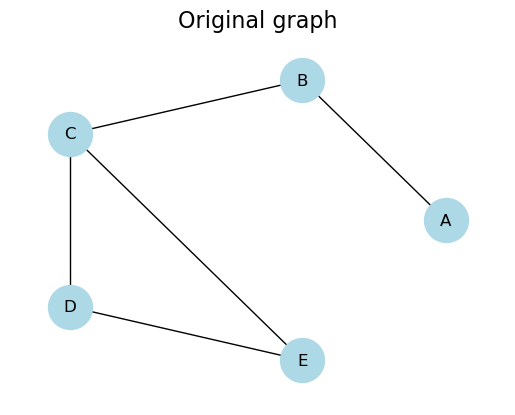

In [5]:
draw(G, 'Original graph')
save('original')

Now we will visualize the selective long-range connections algorithm for this graph with the parameter `k=2`. This means that each node will be connected to nodes with a distance of at least 2. We will visualize the process step by step.

In [6]:
k = 2

# Transformed grpah T (initially no edges)
T = nx.Graph()
T.add_nodes_from(G.nodes(data=True))

In [7]:
def draw_distance_tag(node, dist):
    """Draws a distance tag for a node indicating the distance to another node"""
    x, y = pos[node]
    plt.text(x + 0.2, y + 0.1,
             s=f"d:{dist}", 
             bbox=dict(
                 boxstyle='round,pad=0.3', 
                 facecolor='red',
                 alpha=0.2,
                 edgecolor='none'),
             horizontalalignment='center')

def show_distances_from(source, distances):    
    colors = ['orange' if node == source else 'lightblue' for node in G.nodes()]

    draw(G, f'Transformation (k={k})', colors)
    for node in pos:
        if node == source:
            continue
        draw_distance_tag(node, distances[node])

    save(f'step_{source}')
    plt.show()

def draw_comp(source, comp, dist):
    nodes = list(G.nodes())

    colors = ['lightblue'] * len(nodes)
    colors[nodes.index(source)] = 'orange'
    
    if dist < k:
        criterion = f'{dist} ≱ {k}'
        colors[nodes.index(comp)] = 'red'
    else:
        criterion = f'{dist} ≥ {k}'
        colors[nodes.index(comp)] = 'green'
        T.add_edge(source, comp)
    
    draw(T, f'Transformation (k={k})', colors, shadow=True)
    draw_distance_tag(comp, dist)
    
    plt.text(0, 0, s=f"{criterion}", horizontalalignment='center', fontsize=20, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=1))
    
    save(f'step_{source}_{comp}')
    plt.show()

Node: A


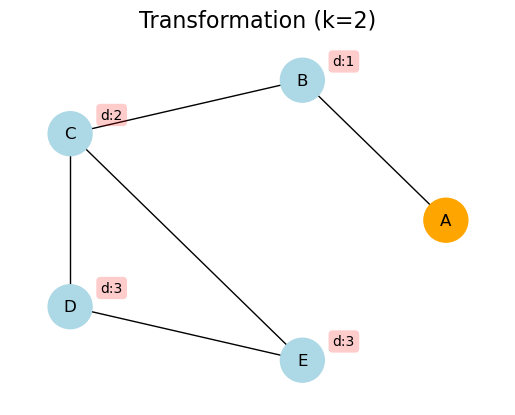

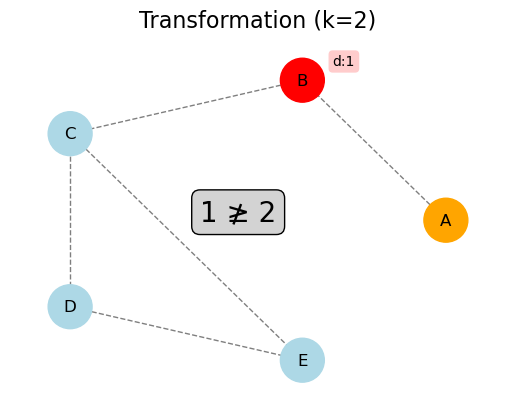

/tmp/ipykernel_746338/3438395696.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos=pos)


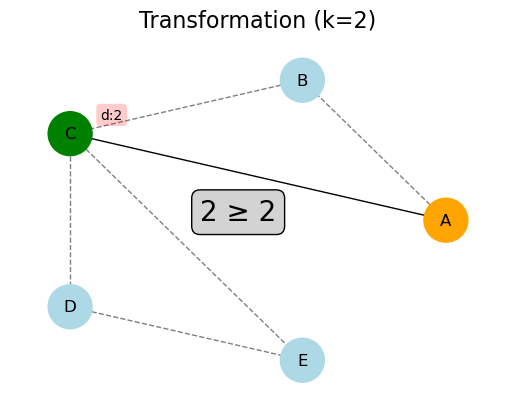

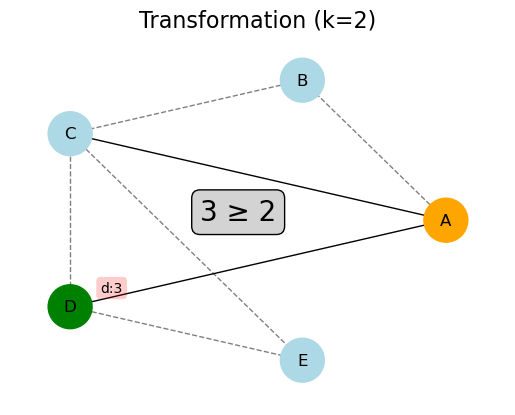

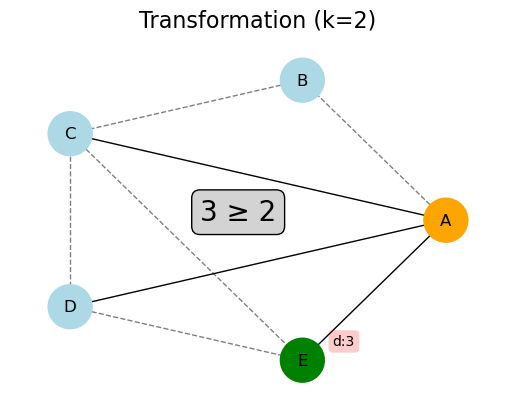

Node: B


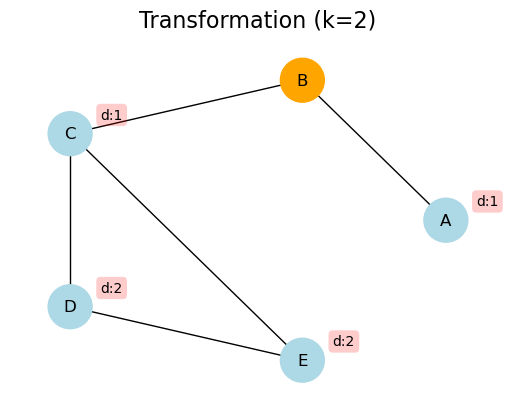

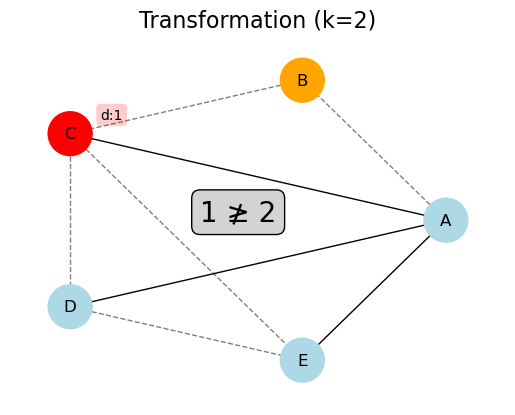

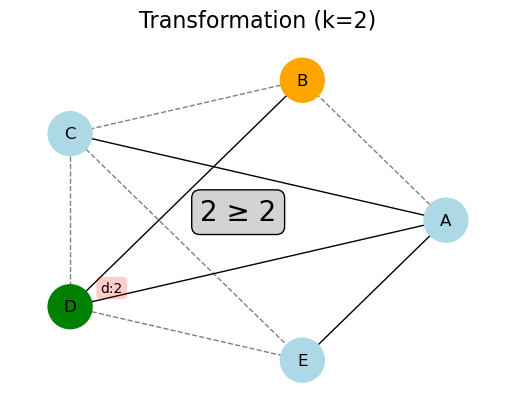

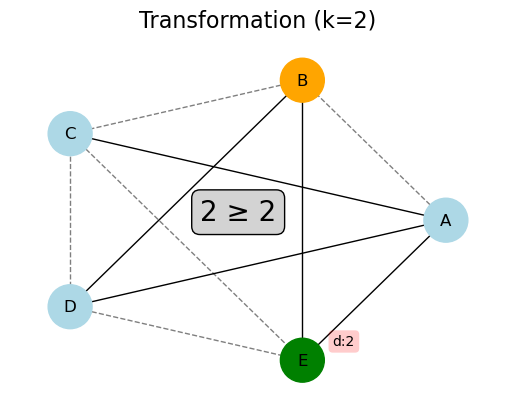

Node: C


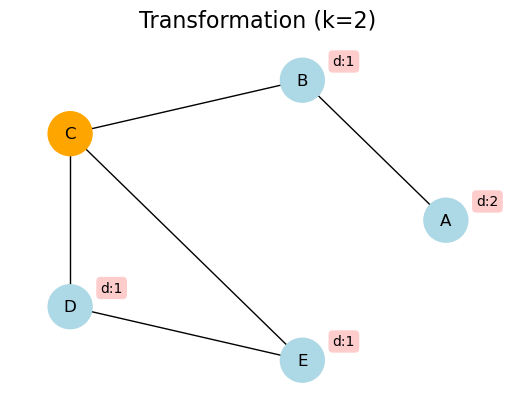

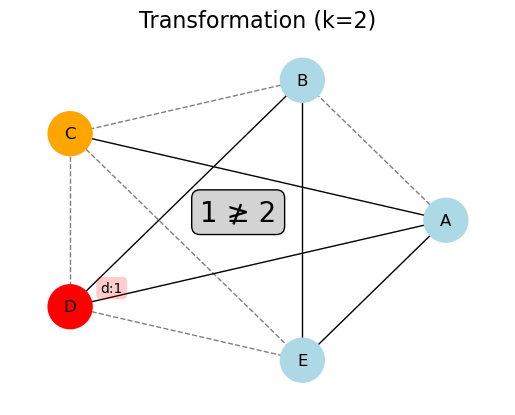

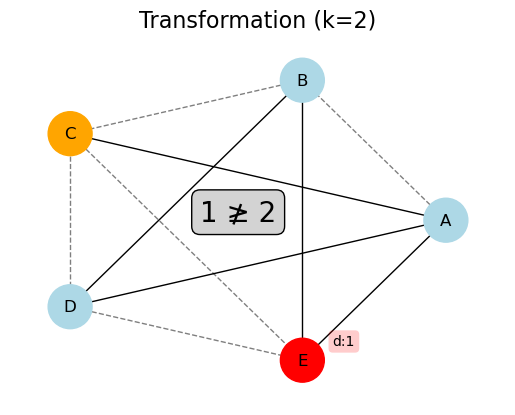

Node: D


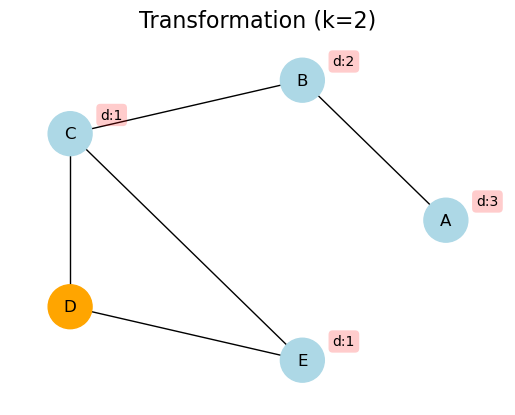

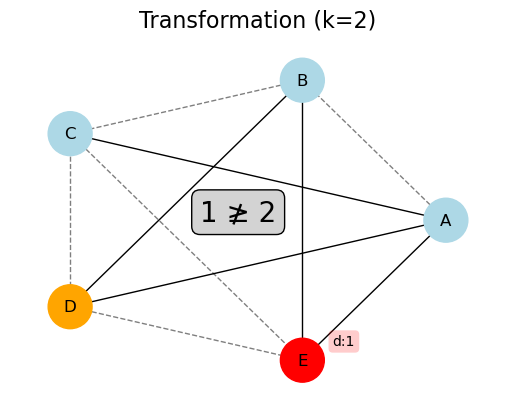

Node: E


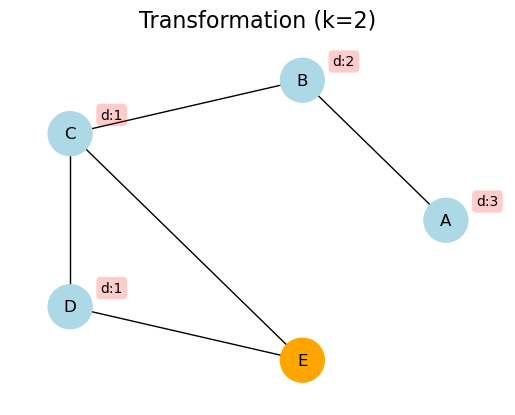

In [8]:
nodes_left = list(G.nodes())
for node in G.nodes():
    print(f'Node: {node}') 
    distances = nx.single_source_shortest_path_length(G, node)
    show_distances_from(node, distances)
    
    nodes_left.remove(node)
    
    for comp in nodes_left:
        draw_comp(node, comp, distances[comp])

Now let's observe the final result of the algorithm.

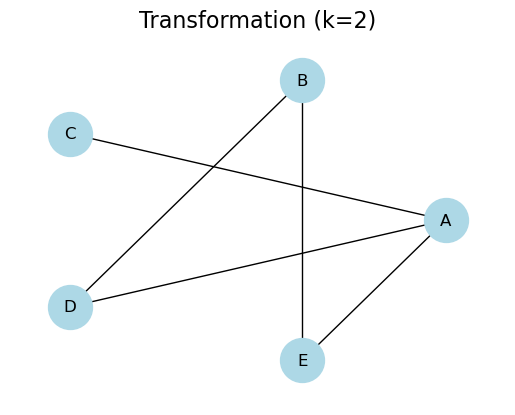

In [9]:
draw(T, f'Transformation (k={k})', shadow=False)
save('final')

## Example transformation on ZINC graphs

In [10]:
from tasks.zinc_dataset import Zinc
from torch_geometric.utils import to_networkx
from slrc import create_k_hop_graph

zinc, _ = Zinc().get_dataset(10, {
    'do_generation': False
    })

/home/maxl/anaconda3/envs/selective-long-range-connection-gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


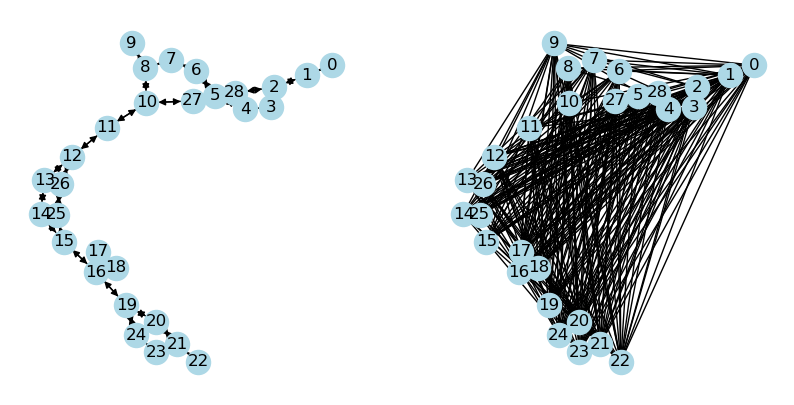

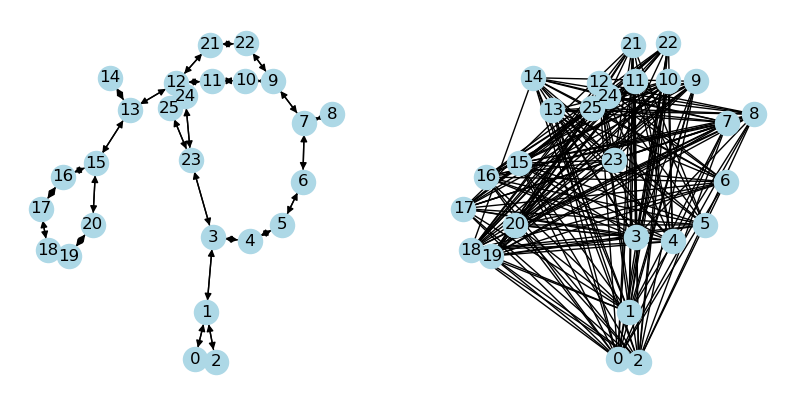

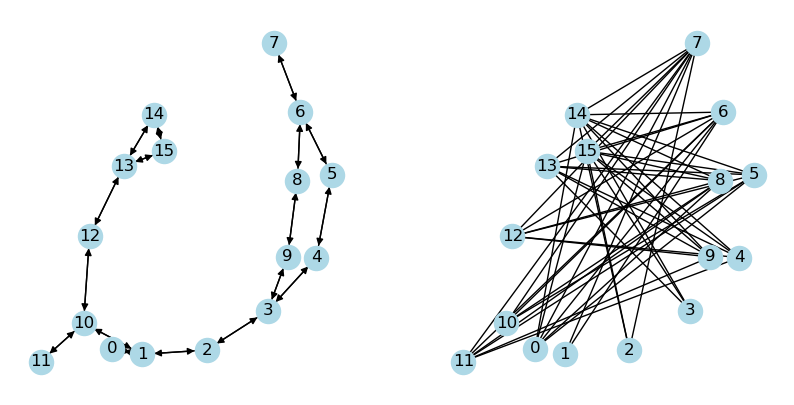

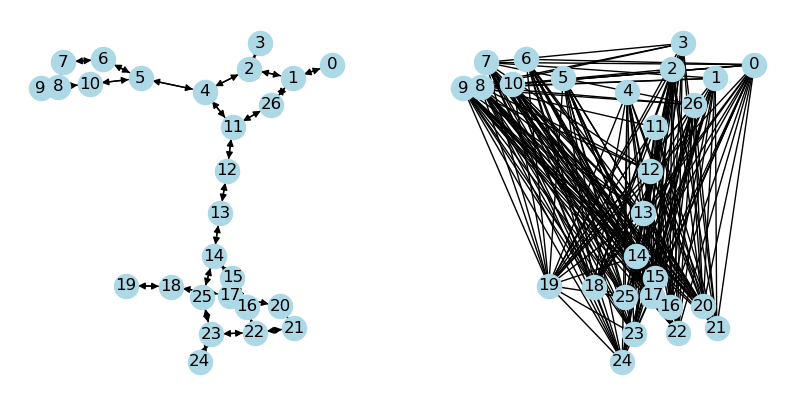

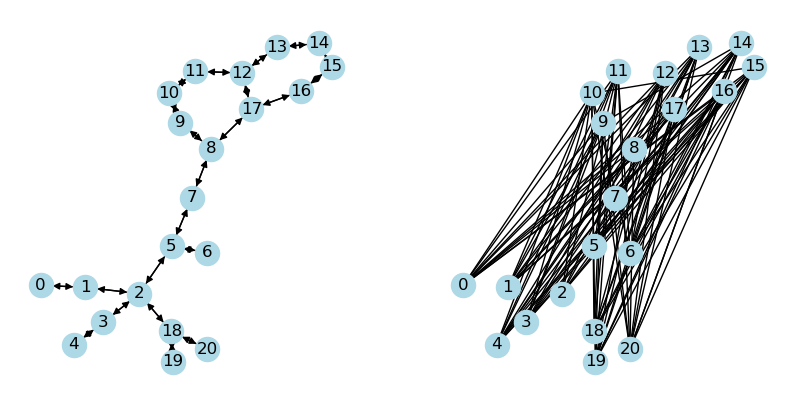

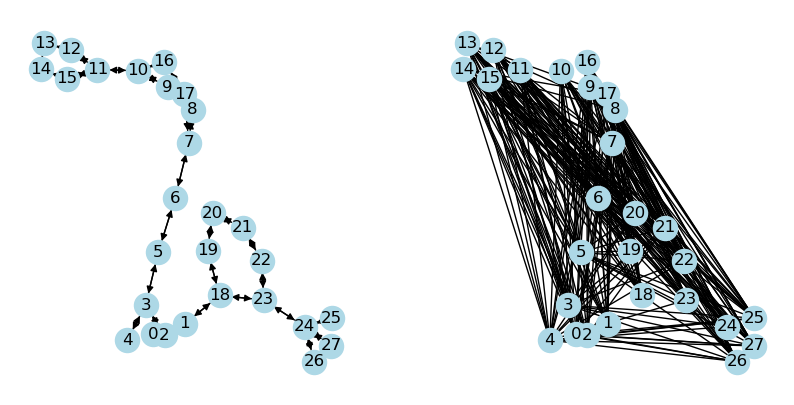

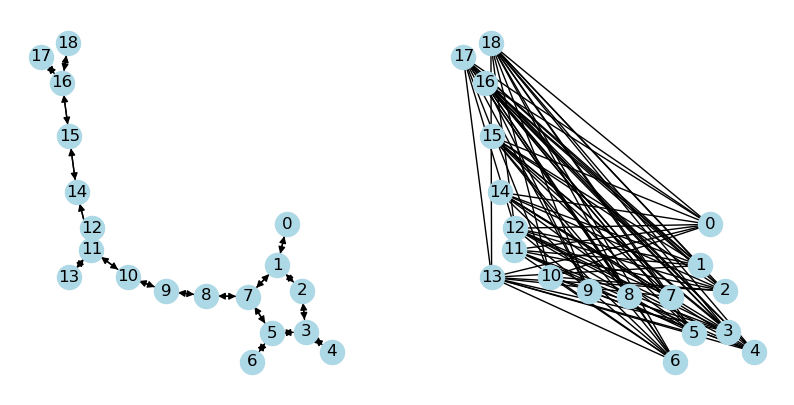

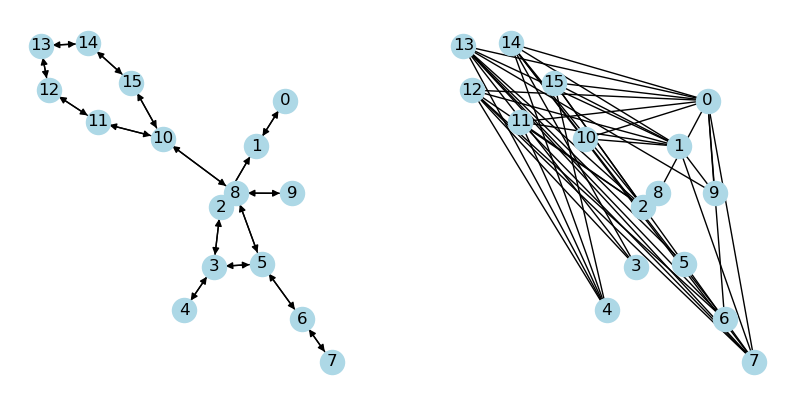

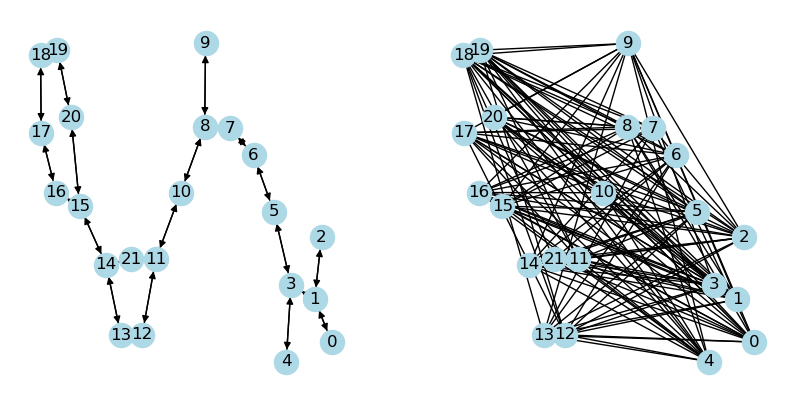

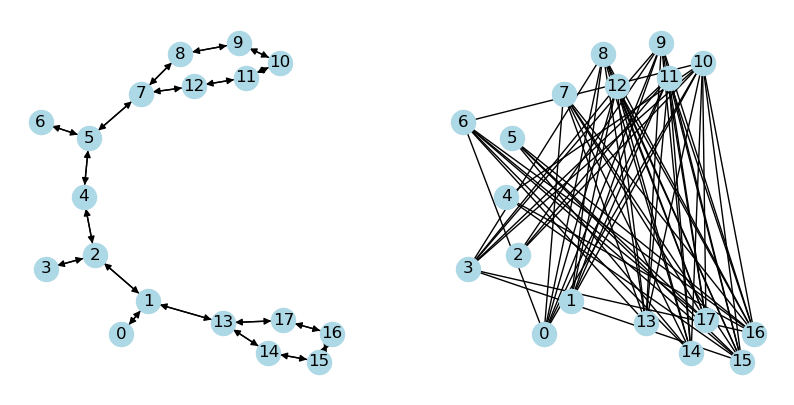

In [11]:
np.random.seed(0)

for i, graph in enumerate(zinc):
    graph = to_networkx(graph)
    T = create_k_hop_graph(graph, k=5)
    
    pos = nx.spring_layout(graph)

    # Plot graph and slrc transformed graph
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    nx.draw(graph, with_labels=True, pos=pos, node_color='lightblue')
    plt.subplot(122)
    nx.draw(T, with_labels=True, pos=pos, node_color='lightblue')

    if i == 9:
        # Save the last plot
        plt.savefig(f'./img/zinc_slrc_transform.png', dpi=300, bbox_inches="tight", format="png")

    plt.show()